In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import nltk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
#nltk.download()
from datetime import datetime
from dateutil import tz
import copy
import pickle
from sklearn import preprocessing


# Reddit Mental Health Comment Clustering

## Loading in the Data

In [2]:
anxiety_comments = pd.read_csv('hella_data/Anxiety_comments_sub201505.csv')
anxiety_posts = pd.read_csv('hella_data/Anxiety_posts_full_corpus_201509.csv')
anxiety_posts = anxiety_posts.set_index('name')
anxiety_comments = anxiety_comments.set_index('name')

/Users/alinxie/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preliminary: Anxiety Data Set

In [3]:
anxiety_comments = pd.read_csv('hella_data/Anxiety_comments_sub201505.csv')
anxiety_posts = pd.read_csv('hella_data/Anxiety_posts_full_corpus_201509.csv')
anxiety_posts = anxiety_posts.set_index('name')
anxiety_comments = anxiety_comments.set_index('name')
anxiety_comments.drop(['score_hidden','archived','author_flair_text','downs','retrieved_on', 'controversiality', 'gilded','ups','distinguished','author_flair_css_class', 'removal_reason'], axis = 1, inplace = True)
anxiety_comments['deleted'] = anxiety_comments['body'] == '[deleted]'
anxiety_comments

/Users/alinxie/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,body,author,created_utc,subreddit_id,link_id,parent_id,score,id,subreddit,deleted
name,,,,,,,,,,
t1_c0dmqpc,Where?,cinsere,1254002472,t5_2qmij,t3_97ek7,t3_97ek7,3,c0dmqpc,Anxiety,False
t1_c0ari6c,These tips are totally easy to implement and t...,webbedenterprisesinc,1246568854,t5_2qmij,t3_8xquv,t3_8xquv,1,c0ari6c,Anxiety,False
t1_cehnsp1,[deleted],[deleted],1388899234,t5_2qmij,t3_1ufvns,t3_1ufvns,14,cehnsp1,Anxiety,True
t1_cj8vup9,[deleted],[deleted],1406433640,t5_2qmij,t3_2bt7fv,t1_cj8pm48,-4,cj8vup9,Anxiety,True
t1_cim8c6p,My anxiety is triggered by unplanned events or...,mutantruby,1404263262,t5_2qmij,t3_29ll4u,t3_29ll4u,61,cim8c6p,Anxiety,False
t1_ckcjnvj,The only way I found out about my anxiety was ...,ServeChilled,1410192814,t5_2qmij,t3_2ft4y0,t3_2ft4y0,44,ckcjnvj,Anxiety,False
t1_cjqo1bv,[deleted],[deleted],1408070450,t5_2qmij,t3_2cqzhs,t1_cjkkl6f,0,cjqo1bv,Anxiety,True
t1_chletov,[deleted],[deleted],1400462152,t5_2qmij,t3_25wgp0,t3_25wgp0,0,chletov,Anxiety,True
t1_cgy220d,Thank you :-),B0o,1398085841,t5_2qmij,t3_23k6em,t1_cgxz3l0,0,cgy220d,Anxiety,False


In [7]:
anxiety_comments_meta = anxiety_comments.copy()
anxiety_comments_meta['num_words'] = anxiety_comments_meta['body'].apply(lambda x: len(str(x).split(' ')))
anxiety_comments_meta['post_reply'] = anxiety_comments_meta['parent_id'].apply(lambda x: x[:2] == 't3')
def reply_time_apply_func(row, submission_table, comment_table):
    #Comment and Parent are utc strings
    parent = row['parent_id']
    is_submission = row['post_reply']
    self_created = row['created_utc']
    if is_submission:
        parent_exists = True
        try:
            parent_row = submission_table.loc[parent]
        except KeyError:
            parent_exists = False
            pass
        if parent_exists:
            parent_created = parent_row['created_utc']
            return self_created - parent_created
        else:    
            return None
    else:
        parent_exists = True
        try:
            parent_row = comment_table.loc[parent]
        except KeyError:
            parent_exists = False
            pass
        if parent_exists:
            return self_created - parent_row['created_utc']
        else:
            return 9999
def is_submission_author_func(row, submission_table):
    submission = row['link_id']
    author = row['author']
    parent_exists = True
    try:
        parent_row = submission_table.loc[submission]
    except KeyError:
        parent_exists = False
        pass
    if parent_exists:
        parent_author = parent_row['author']
        return author == parent_author
    else:    
        return None
anxiety_reply_time_func = lambda x: reply_time_apply_func(x, anxiety_posts, anxiety_comments)
anxiety_post_author_func = lambda x: is_submission_author_func(x, anxiety_posts)
anxiety_comments_meta['reply_time'] = anxiety_comments_meta.apply(func = anxiety_reply_time_func, axis = 1, reduce = True)
anxiety_comments_meta['post_author'] = anxiety_comments_meta.apply(func = anxiety_post_author_func, axis = 1, reduce = True)
anxiety_comments_meta

,body,author,created_utc,subreddit_id,link_id,parent_id,score,id,subreddit,deleted,num_words,post_reply,reply_time,post_author
name,,,,,,,,,,,,,,
t1_c0dmqpc,Where?,cinsere,1254002472,t5_2qmij,t3_97ek7,t3_97ek7,3,c0dmqpc,Anxiety,False,1,True,4608682,False
t1_c0ari6c,These tips are totally easy to implement and t...,webbedenterprisesinc,1246568854,t5_2qmij,t3_8xquv,t3_8xquv,1,c0ari6c,Anxiety,False,16,True,23,True
t1_cehnsp1,[deleted],[deleted],1388899234,t5_2qmij,t3_1ufvns,t3_1ufvns,14,cehnsp1,Anxiety,True,1,True,730,False
t1_cj8vup9,[deleted],[deleted],1406433640,t5_2qmij,t3_2bt7fv,t1_cj8pm48,-4,cj8vup9,Anxiety,True,1,False,16037,True
t1_cim8c6p,My anxiety is triggered by unplanned events or...,mutantruby,1404263262,t5_2qmij,t3_29ll4u,t3_29ll4u,61,cim8c6p,Anxiety,False,40,True,11143,False
t1_ckcjnvj,The only way I found out about my anxiety was ...,ServeChilled,1410192814,t5_2qmij,t3_2ft4y0,t3_2ft4y0,44,ckcjnvj,Anxiety,False,657,True,6837,False
t1_cjqo1bv,[deleted],[deleted],1408070450,t5_2qmij,t3_2cqzhs,t1_cjkkl6f,0,cjqo1bv,Anxiety,True,1,False,558523,False
t1_chletov,[deleted],[deleted],1400462152,t5_2qmij,t3_25wgp0,t3_25wgp0,0,chletov,Anxiety,True,1,True,3727,False
t1_cgy220d,Thank you :-),B0o,1398085841,t5_2qmij,t3_23k6em,t1_cgxz3l0,0,cgy220d,Anxiety,False,3,False,16340,True


In [8]:
def bool_to_num(x):
    if x:
        return 1
    else:
        return 0
anxiety_comments_meta['deleted'] = anxiety_comments_meta['deleted'].apply(func = bool_to_num)
anxiety_comments_meta['post_reply'] = anxiety_comments_meta['post_reply'].apply(func = bool_to_num)
anxiety_comments_meta['post_author'] = anxiety_comments_meta['post_author'].apply(func = bool_to_num)
anxiety_comments_meta

,body,author,created_utc,subreddit_id,link_id,parent_id,score,id,subreddit,deleted,num_words,post_reply,reply_time,post_author
name,,,,,,,,,,,,,,
t1_c0dmqpc,Where?,cinsere,1254002472,t5_2qmij,t3_97ek7,t3_97ek7,3,c0dmqpc,Anxiety,0,1,1,4608682,0
t1_c0ari6c,These tips are totally easy to implement and t...,webbedenterprisesinc,1246568854,t5_2qmij,t3_8xquv,t3_8xquv,1,c0ari6c,Anxiety,0,16,1,23,1
t1_cehnsp1,[deleted],[deleted],1388899234,t5_2qmij,t3_1ufvns,t3_1ufvns,14,cehnsp1,Anxiety,1,1,1,730,0
t1_cj8vup9,[deleted],[deleted],1406433640,t5_2qmij,t3_2bt7fv,t1_cj8pm48,-4,cj8vup9,Anxiety,1,1,0,16037,1
t1_cim8c6p,My anxiety is triggered by unplanned events or...,mutantruby,1404263262,t5_2qmij,t3_29ll4u,t3_29ll4u,61,cim8c6p,Anxiety,0,40,1,11143,0
t1_ckcjnvj,The only way I found out about my anxiety was ...,ServeChilled,1410192814,t5_2qmij,t3_2ft4y0,t3_2ft4y0,44,ckcjnvj,Anxiety,0,657,1,6837,0
t1_cjqo1bv,[deleted],[deleted],1408070450,t5_2qmij,t3_2cqzhs,t1_cjkkl6f,0,cjqo1bv,Anxiety,1,1,0,558523,0
t1_chletov,[deleted],[deleted],1400462152,t5_2qmij,t3_25wgp0,t3_25wgp0,0,chletov,Anxiety,1,1,1,3727,0
t1_cgy220d,Thank you :-),B0o,1398085841,t5_2qmij,t3_23k6em,t1_cgxz3l0,0,cgy220d,Anxiety,0,3,0,16340,1


In [9]:
#anxiety_comments_meta = anxiety_comments_meta.drop(anxiety_comments[anxiety_comments_meta['reply_time'] == 9999], inplace = True)
#anxiety_comments_meta= anxiety_comments_meta[anxiety_comments_meta['reply_time'] != 9999]
anxiety_comments_meta = anxiety_comments_meta.dropna()
anxiety_comments_meta.size

4052104

### Running KMeans on Anxiety Comment Dataset

Create a copy of the meta_table, delete non-numerical values

In [43]:
anxiety_meta_cluster = anxiety_comments_meta.copy()
anxiety_meta_cluster = anxiety_meta_cluster.reset_index()
anxiety_meta_cluster.drop(['body', 'name', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'id', 'subreddit'],axis = 1, inplace = True)
#anxiety_meta_cluster.to_csv('new_meta_anxiety.csv')

min_max_scaler = preprocessing.MinMaxScaler()
anxiety_meta_cluster['reply_time'] = min_max_scaler.fit_transform(anxiety_meta_cluster['reply_time'])
anxiety_meta_cluster['num_words'] = min_max_scaler.fit_transform(anxiety_meta_cluster['num_words'])
anxiety_meta_cluster['score'] = min_max_scaler.fit_transform(anxiety_meta_cluster['score'])
anxiety_meta_cluster

/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alinxie/an

,score,deleted,num_words,post_reply,reply_time,post_author
0,0.197719,0,0.000000,1,1.882176e-01,0
1,0.190114,0,0.006405,1,8.984755e-07,1
2,0.239544,1,0.000000,1,2.977221e-05,0
3,0.171103,1,0.000000,0,6.549070e-04,1
4,0.418251,0,0.016652,1,4.550370e-04,0
5,0.353612,0,0.280102,1,2.791809e-04,0
6,0.186312,1,0.000000,0,2.280993e-02,0
7,0.186312,1,0.000000,1,1.521691e-04,0
8,0.186312,0,0.000854,0,6.672814e-04,1
9,0.186312,0,0.051665,1,1.809652e-03,0


In [44]:
list(anxiety_meta_cluster)

['score', 'deleted', 'num_words', 'post_reply', 'reply_time', 'post_author']

In [45]:
anxiety_comment_mat = anxiety_meta_cluster.as_matrix()
anxiety_km = KMeans(n_clusters = 20)
anxiety_km.fit(anxiety_comment_mat)

KeyboardInterrupt: 

Do KMeans on sample

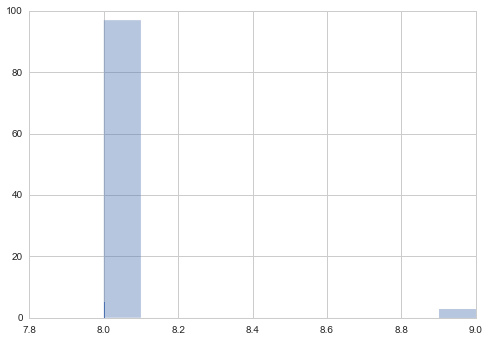

In [73]:
maxes = []
for i in range(0,100):
    cluster_sizes = range(2, 21)
    #silhouette_scores = []
    cut = 500
    max_score = -1
    for size in cluster_sizes:
        sample_test = anxiety_meta_cluster.sample(cut, replace = False)
        sample_test_mat = sample_test.as_matrix()
        sample_kmeans = KMeans(n_clusters = size)
        labs = sample_kmeans.fit_predict(sample_test_mat)
        sil_score = silhouette_score(sample_test_mat, labs)
        if sil_score > max_score:
            max_score = sil_score
            max_cluster_size = size
    maxes.append(max_cluster_size)
    # plt.bar(cluster_sizes, silhouette_scores)
    # plt.show()
    #sns.barplot(cluster_sizes, silhouette_scores)
sns.distplot(maxes, kde=False, rug=True)

Do KMeans on entire sample and then Sample (significantly more processing time)

{2: (0.30874284211175768, 0.0034828439910489506),
 3: (0.78715458339446542, 0.0012268138824786474),
 4: (0.83841204459405172, 0.0011221402691728437),
 5: (0.87862955270446075, 0.00093093414407233361),
 6: (0.91468049528681439, 0.00057399254015325118),
 7: (0.92309242207649134, 0.00060147619845737747),
 8: (0.95049250318686385, 0.00011904762893232824),
 9: (0.8054393957800603, 0.0014675856361228902)}

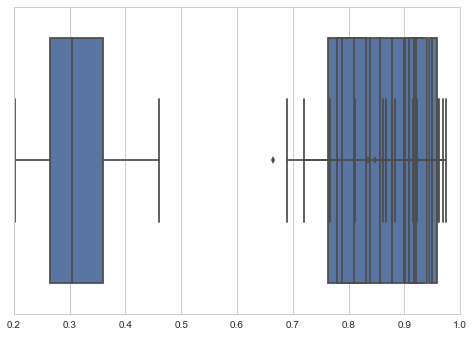

In [119]:
silhouette_test_2(anxiety_meta_cluster)

## Clusters on all the Data

In [143]:
##############Putting in functions from before######################
def get_reply_time(row, submission_table, comment_table):
    #Comment and Parent are utc strings
    parent = row['parent_id']
    is_submission = row['post_reply']
    self_created = row['created_utc']
    if is_submission:
        parent_exists = True
        try:
            parent_row = submission_table.loc[parent]
        except KeyError:
            parent_exists = False
            pass
        if parent_exists:
            parent_created = parent_row['created_utc']
            return self_created - parent_created
        else:    
            return None
    else:
        parent_exists = True
        try:
            parent_row = comment_table.loc[parent]
        except KeyError:
            parent_exists = False
            pass
        if parent_exists:
            return self_created - parent_row['created_utc']
        else:
            return None
        
def is_submission_author(row, submission_table):
    submission = row['link_id']
    author = row['author']
    parent_exists = True
    try:
        parent_row = submission_table.loc[submission]
    except KeyError:
        parent_exists = False
        pass
    if parent_exists:
        parent_author = parent_row['author']
        return author == parent_author
    else:    
        return None
    
def bool_to_num(x):
    if x:
        return 1
    else:
        return 0
    
##########################################################
# Takes in the comment table, the post table, processes metadata, and runs kmeans on the 
def master_cluster_comment_meta_data(comment_table, post_table, n_clusters):
    comment_table_with_meta_data, kmeans_input = preprocess_meta_data(comment_table, post_table)
    kmeans_mat = kmeans_input.as_matrix()
    km = KMeans(n_clusters = n_clusters)
    km.fit(kmeans_mat)
    return comment_table_with_meta_data, km, kmeans_input

def preprocess_meta_data(comment_table, post_table):
    comment_table = comment_table.copy().set_index('name')
    post_table = post_table.copy().set_index('name')
    comment_table.drop(['score_hidden','archived','author_flair_text','downs','retrieved_on', 'controversiality', 'gilded','ups','distinguished','author_flair_css_class', 'removal_reason'], axis = 1, inplace = True)
    comment_meta_data = comment_table.copy()
    comment_meta_data['deleted'] = comment_meta_data['body'] == '[deleted]'
    comment_meta_data['num_words'] = comment_meta_data['body'].apply(lambda x: len(str(x).split(' ')))
    comment_meta_data['post_reply'] = comment_meta_data['parent_id'].apply(lambda x: x[:2] == 't3')
    reply_time_func = lambda x: get_reply_time(x, post_table, comment_table)
    post_author_func = lambda x: is_submission_author(x, post_table)
    comment_meta_data['reply_time'] = comment_meta_data.apply(func = reply_time_func, axis = 1, reduce = True)
    comment_meta_data['post_author'] = comment_meta_data.apply(func = post_author_func, axis = 1, reduce = True)
    comment_meta_data['deleted'] = comment_meta_data['deleted'].apply(func = bool_to_num)
    comment_meta_data['post_reply'] = comment_meta_data['post_reply'].apply(func = bool_to_num)
    comment_meta_data['post_author'] = comment_meta_data['post_author'].apply(func = bool_to_num)
    comment_meta_data = comment_meta_data.dropna()
    #Scaling/normalizing
    min_max_scaler = preprocessing.MinMaxScaler()
    comment_meta_data['reply_time'] = min_max_scaler.fit_transform(comment_meta_data['reply_time'])
    comment_meta_data['num_words'] = min_max_scaler.fit_transform(comment_meta_data['num_words'])
    comment_meta_data['score'] = min_max_scaler.fit_transform(comment_meta_data['score'])
    result = comment_meta_data.copy()
    result = result.reset_index()
    result.drop(['body', 'name', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'id', 'subreddit'],axis = 1, inplace = True)
    return comment_meta_data, result

def silhouette_test(kmeans_input):
    maxes = []
    for i in range(0,100):
        cluster_sizes = range(2, 21)
        #silhouette_scores = []
        cut = 500
        max_score = -1
        for size in cluster_sizes:
            sample_input = kmeans_input.sample(cut, replace = False)
            sample_input_mat = sample_input.as_matrix()
            sample_kmeans = KMeans(n_clusters = size)
            labs = sample_kmeans.fit_predict(sample_input_mat)
            sil_score = silhouette_score(sample_input_mat, labs)
            if sil_score > max_score:
                max_score = sil_score
                max_cluster_size = size
        maxes.append(max_cluster_size)
        # plt.bar(cluster_sizes, silhouette_scores)
        # plt.show()
        #sns.barplot(cluster_sizes, silhouette_scores)
    sns.distplot(maxes, kde=False, rug=True)
    return maxes

def silhouette_test_2(kmeans_input):
    averages = {}
    cluster_sizes = range(2, 10)
    #silhouette_scores = []
    cut = 100
    for size in cluster_sizes:
        kmeans_input_mat = kmeans_input.as_matrix()
        km = KMeans(n_clusters = size)
        kmeans_input['labs'] = km.fit_predict(kmeans_input_mat)
        sil_scores = []
        for i in range(0,100):
            kmeans_sample = kmeans_input.sample(cut, replace = False)
            sample_features = kmeans_sample.drop(['labs'], axis = 1).as_matrix()
            sil_scores.append(silhouette_score(sample_features, kmeans_sample['labs']))
        #sns.boxplot(sil_scores)
        averages[size] = (np.mean(sil_scores),np.var(sil_scores))
        # plt.bar(cluster_sizes, silhouette_scores)
        # plt.show()
        #sns.boxplot(cluster_sizes)
    kmeans_input.drop(['labs'], axis = 1, inplace = True)
    return averages

def silhouette_score_dist(kmeans_input, n_clusters):
    km_input = kmeans_input.copy()
    kmeans_input_mat = km_input.as_matrix()
    km = KMeans(n_clusters = n_clusters)
    km_input['labs'] = km.fit_predict(kmeans_input_mat)
    sil_scores = []
    for i in range(0,1000):
        kmeans_sample = km_input.sample(2000, replace = False)
        sample_features = kmeans_sample.drop(['labs'], axis = 1).as_matrix()
        sil_scores.append(silhouette_score(sample_features, kmeans_sample['labs']))
    #sns.boxplot(sil_scores)
    sns.distplot(sil_scores, kde = False, rug=True)
    return np.mean(sil_scores), np.var(sil_scores)

def kmeans(kmeans_input):
    kmeans_mat = kmeans_input.as_matrix()
    km = KMeans(n_clusters = n_clusters)
    km.fit(kmeans_mat)
    return km

0.96253603725986792

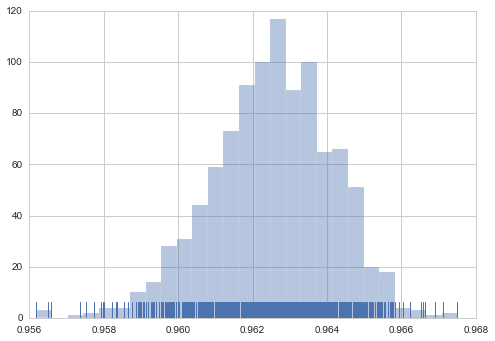

In [142]:

#Test on anxiety dataset
silhouette_score_dist(anxiety_meta_cluster, 8)


In [75]:
# Get the metadata for comments and get silhouette score metrics for clusters through k-means on differing numbers of clusters.

def master_cluster_comment_meta_data_Orianna(comment_table, post_table, cluster_nums):
    comment_table = comment_table.copy().set_index('name')
    post_table = post_table.copy().set_index('name')
    comment_table.drop(['score_hidden','archived','author_flair_text','downs','retrieved_on', 'controversiality', 'gilded','ups','distinguished','author_flair_css_class', 'removal_reason'], axis = 1, inplace = True)
    comment_meta_data = comment_table.copy()
    comment_meta_data['deleted'] = comment_meta_data['body'] == '[deleted]'
    comment_meta_data['num_words'] = comment_meta_data['body'].apply(lambda x: len(str(x).split(' ')))
    comment_meta_data['post_reply'] = comment_meta_data['parent_id'].apply(lambda x: x[:2] == 't3')
    reply_time_func = lambda x: get_reply_time(x, post_table, comment_table)
    post_author_func = lambda x: is_submission_author(x, post_table)
    comment_meta_data['reply_time'] = comment_meta_data.apply(func = reply_time_func, axis = 1, reduce = True)
    comment_meta_data['post_author'] = comment_meta_data.apply(func = post_author_func, axis = 1, reduce = True)
    comment_meta_data['deleted'] = comment_meta_data['deleted'].apply(func = bool_to_num)
    comment_meta_data['post_reply'] = comment_meta_data['post_reply'].apply(func = bool_to_num)
    comment_meta_data['post_author'] = comment_meta_data['post_author'].apply(func = bool_to_num)
    comment_meta_data = comment_meta_data.dropna()
    kmeans_input = comment_meta_data.copy()
    kmeans_input = kmeans_input.reset_index()
    kmeans_input.drop(['body', 'name', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'id', 'subreddit'],axis = 1, inplace = True)
    kmeans_mat = kmeans_input.as_matrix()
    
    cluster_metric = np.NaN * np.zeros(len(cluster_nums))
    kms = []
    for i, n_clusters in enumerate(cluster_nums): # = [2, 5, 10, 25, 50 100, 150]
        km = KMeans(n_clusters = n_clusters)
        km.fit(kmeans_input)
        kms.append(copy.copy(km))
        cluster_metric[i] = silhouette_score(kmeans_input, km.labels_)
    
    return comment_meta_data, cluster_metric, kms

#Make plt.plot(cluster_nums, cluster_metric,'-.')
# choose best # clusters. 
# open clusters: look at comments closest to center of clusters - do they have anything in common? 
# Look distribution of comments from different SR's between the clusters. 

# GMM's Gaussian Mixture Modes - Metric: Likelihood of the data

Load all the data, concatenate posts and comments

In [76]:
anxiety_comments = pd.read_csv('hella_data/Anxiety_comments_sub201505.csv')
anxiety_posts = pd.read_csv('hella_data/Anxiety_posts_full_corpus_201509.csv')
BipolarReddit_comments = pd.read_csv('hella_data/BipolarReddit_comments_sub201505.csv')
BipolarReddit_posts = pd.read_csv('hella_data/BipolarReddit_posts_full_corpus_201509.csv')
BPD_comments = pd.read_csv('hella_data/BPD_comments_sub201505.csv')
BPD_posts = pd.read_csv('hella_data/BPD_posts_full_corpus_201509.csv')
BipolarSOs_comments = pd.read_csv('hella_data/BipolarSOs_comments_sub201505.csv')
BipolarSOs_posts = pd.read_csv('hella_data/BipolarSOs_posts_full_corpus_201509.csv')
MMFB_comments = pd.read_csv('hella_data/MMFB_comments_sub201505.csv')
StopSelfHarm_comments = pd.read_csv('hella_data/StopSelfHarm_comments_sub201505.csv')
StopSelfHarm_posts = pd.read_csv('hella_data/StopSelfHarm_posts_full_corpus_201509.csv')
depression_comments = pd.read_csv('hella_data/depression_comments_sub201505.csv')
depression_posts = pd.read_csv('hella_data/depression_posts_full_corpus_201509.csv')
schizophrenia_comments = pd.read_csv('hella_data/schizophrenia_comments_sub201505.csv')
schizophrenia_posts = pd.read_csv('hella_data/schizophrenia_posts_full_corpus_201509.csv')
socialanxiety_comments = pd.read_csv('hella_data/socialanxiety_comments_sub201505.csv')
socialanxiety_posts = pd.read_csv('hella_data/socialanxiety_posts_full_corpus_201509.csv')
bipolar_posts  = pd.read_csv('hella_data/subreddit_bipolar.csv')
bipolar_comments = pd.read_csv('hella_data/subreddit_bipolar_comments_sub201505.csv')
post_frames = [anxiety_posts, BipolarReddit_posts, BPD_posts, BipolarSOs_posts, StopSelfHarm_posts, depression_posts, schizophrenia_posts, socialanxiety_posts, bipolar_posts]
comment_frames = [anxiety_comments, BipolarReddit_comments, BPD_comments, BipolarSOs_comments, StopSelfHarm_comments, depression_comments, schizophrenia_comments, socialanxiety_comments, bipolar_comments]
master_posts = pd.concat(post_frames)
master_comments = pd.concat(comment_frames)

/Users/alinxie/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/alinxie/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
master_comment_meta_data, master_kmeans_input = preprocess_meta_data(master_comments, master_posts)

/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alinxie/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/alinxie/an

In [91]:
master_kmeans_input.describe()


,score,deleted,num_words,post_reply,reply_time,post_author
count,1.756597e+06,1.756597e+06,1.756597e+06,1.756597e+06,1.756597e+06,1.756597e+06
mean,6.313302e-02,1.191634e-01,1.645760e-02,5.160575e-01,2.952912e-03,2.512528e-01
std,2.448330e-03,3.239807e-01,2.397640e-02,4.997422e-01,2.436317e-02,4.337337e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.269716e-02,0.000000e+00,2.618487e-03,0.000000e+00,7.310324e-05,0.000000e+00
50%,6.269716e-02,0.000000e+00,8.902854e-03,1.000000e+00,3.887132e-04,0.000000e+00
75%,6.309148e-02,0.000000e+00,2.094789e-02,1.000000e+00,1.233444e-03,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [145]:
averages = silhouette_test_2(master_kmeans_input)

(0.97802928437047287, 1.521994032366235e-06)

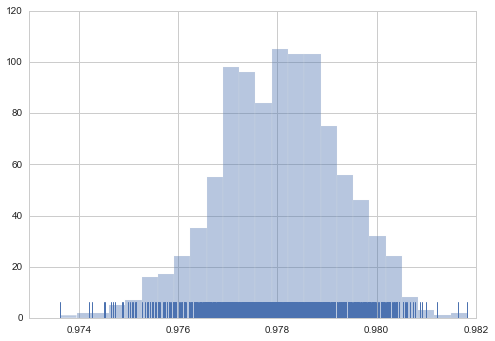

In [149]:
silhouette_score_dist(master_kmeans_input, 8)

In [10]:
master_comment_meta_data, master_kmeans, master_input = master_cluster_comment_meta_data(master_comments, master_posts, 5)
master_comment_meta_data = master_comment_meta_data.reset_index()
master_comment_meta_data['classification_label'] = master_kmeans.labels_
master_comment_meta_data

,name,body,author,created_utc,subreddit_id,link_id,parent_id,score,id,subreddit,deleted,num_words,post_reply,reply_time,post_author,classification_label
0,t1_c0dmqpc,Where?,cinsere,1254002472,t5_2qmij,t3_97ek7,t3_97ek7,3,c0dmqpc,Anxiety,0,1,1,4608682.0,0,2
1,t1_c0ari6c,These tips are totally easy to implement and t...,webbedenterprisesinc,1246568854,t5_2qmij,t3_8xquv,t3_8xquv,1,c0ari6c,Anxiety,0,16,1,23.0,1,0
2,t1_cehnsp1,[deleted],[deleted],1388899234,t5_2qmij,t3_1ufvns,t3_1ufvns,14,cehnsp1,Anxiety,1,1,1,730.0,0,0
3,t1_cj8vup9,[deleted],[deleted],1406433640,t5_2qmij,t3_2bt7fv,t1_cj8pm48,-4,cj8vup9,Anxiety,1,1,0,16037.0,1,0
4,t1_cim8c6p,My anxiety is triggered by unplanned events or...,mutantruby,1404263262,t5_2qmij,t3_29ll4u,t3_29ll4u,61,cim8c6p,Anxiety,0,40,1,11143.0,0,0
5,t1_ckcjnvj,The only way I found out about my anxiety was ...,ServeChilled,1410192814,t5_2qmij,t3_2ft4y0,t3_2ft4y0,44,ckcjnvj,Anxiety,0,657,1,6837.0,0,0
6,t1_cjqo1bv,[deleted],[deleted],1408070450,t5_2qmij,t3_2cqzhs,t1_cjkkl6f,0,cjqo1bv,Anxiety,1,1,0,558523.0,0,0
7,t1_chletov,[deleted],[deleted],1400462152,t5_2qmij,t3_25wgp0,t3_25wgp0,0,chletov,Anxiety,1,1,1,3727.0,0,0
8,t1_cgy220d,Thank you :-),B0o,1398085841,t5_2qmij,t3_23k6em,t1_cgxz3l0,0,cgy220d,Anxiety,0,3,0,16340.0,1,0
9,t1_cg68tcd,"Sometimes I think I see spots, but I'm not sur...",TinBritches,1395201722,t5_2qmij,t3_20q3w1,t3_20q3w1,0,cg68tcd,Anxiety,0,122,1,44312.0,0,0


## Trying to get silhouette distance on large amount of data

In [15]:
#master_comment_meta_data.to_csv('master_comment_clusters.csv')
i = master_input.as_matrix()
labs = master_kmeans.labels_
# silhouette_score(i, labs)

In [94]:
import pickle
output = open('input_normalized.pkl', 'wb')
#output2 = open('labs.pkl', 'wb')
pickle.dump(master_kmeans_input.as_matrix(), output)
#pickle.dump(labs, output2)
output.close()
#output2.close()

In [3]:
i_file = open('input.pkl', 'rb')
labs_file = open('labs.pkl', 'rb')
i = pickle.load(i_file)
labs = pickle.load(labs_file)
i_file.close()
labs_file.close()

array([[  3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   4.60868200e+06,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   1.60000000e+01,
          1.00000000e+00,   2.30000000e+01,   1.00000000e+00],
       [  1.40000000e+01,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   7.30000000e+02,   0.00000000e+00],
       ..., 
       [  2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   9.90697000e+05,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   3.90000000e+01,
          0.00000000e+00,   8.61000000e+02,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   8.00000000e+00,
          0.00000000e+00,   3.85000000e+02,   0.00000000e+00]])

In [ ]:
silhouette_score(i, labs)

In [9]:

data = np.array([[1,2],[1,3], [1,2], [0,0], [3,4], [1,2], [5,6]])
clusters = KMeans(n_clusters = 2)
clusters.fit(data)
sklearn.metrics.silhouette_score(data, clusters.labels_)

0.60606495551543671

In [ ]:
comment_meta_data, meta_metric, meta_kmeans = master_cluster_comment_meta_data_Orianna(master_comments, master_posts, [2,5])

In [ ]:
print('hi')

# Comment Word Clustering